# Aircraft Engine RUL Prediction

## Project Goal
Predict the Remaining Useful Life (RUL) of aircraft engines using sensor data from NASA's C-MAPSS dataset. This is for predictive maintenance - basically trying to figure out when an engine might fail before it actually does.

## Dataset Info
- Using NASA C-MAPSS FD001 dataset
- Has training data from 100 engines that ran until failure
- Test data from 100 more engines (but we don't see them fail)
- Each engine has 21 different sensor readings per cycle

In [2]:
# Import all the libraries I need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings

# Don't want to see all the warnings
warnings.filterwarnings('ignore')

## Step 1: Load and Clean the Data

First thing is to load the NASA dataset. The files are in a weird format (space-separated) so need to handle that properly.

In [3]:
print("--- Step 1: Loading and Preprocessing Data ---")

# Set up column names based on what I read about the NASA dataset
index_cols = ['unit_number', 'time_in_cycles']
setting_cols = ['setting_1', 'setting_2', 'setting_3']  # operational settings
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]     # 21 sensors
col_names = index_cols + setting_cols + sensor_cols

# Load the datasets - using \s+ because they're space separated
try:
    train_df = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)
    test_df = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=col_names)
    rul_df = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])
except FileNotFoundError:
    print("Error: Can't find the dataset files!")
    print("Make sure train_FD001.txt, test_FD001.txt, and RUL_FD001.txt are in the same folder")
    exit()

# Keep track of test set info for plotting later
test_df_ids = test_df[['unit_number', 'time_in_cycles']].copy()

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"RUL data shape: {rul_df.shape}")

--- Step 1: Loading and Preprocessing Data ---
Training data shape: (20631, 26)
Test data shape: (13096, 26)
RUL data shape: (100, 1)


In [4]:
# Remove useless columns - some sensors and settings don't change much
# Found this by exploring the data (not shown here to keep notebook clean)
useless_cols = ['setting_1', 'setting_2', 'setting_3', 'sensor_1', 'sensor_5',
               'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']

train_df.drop(columns=useless_cols, inplace=True)
test_df.drop(columns=useless_cols, inplace=True)

print("Dropped constant/low-variance columns")
print(f"New training shape: {train_df.shape}")

Dropped constant/low-variance columns
New training shape: (20631, 16)


## Step 2: Calculate RUL (Remaining Useful Life)

This is the tricky part. For training data, I need to calculate how many cycles are left until failure. For test data, I have to use the provided RUL file to figure this out.

In [5]:
print("\n--- Step 2: Calculating RUL ---")

# For training: RUL = max_cycles - current_cycle for each engine
train_max_cycles = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
train_max_cycles.columns = ['unit_number', 'max_time_in_cycles']
train_df = train_df.merge(train_max_cycles, on='unit_number', how='left')
train_df['RUL'] = train_df['max_time_in_cycles'] - train_df['time_in_cycles']
train_df.drop(columns=['max_time_in_cycles'], inplace=True)

print(f"Training RUL range: {train_df['RUL'].min()} to {train_df['RUL'].max()}")


--- Step 2: Calculating RUL ---
Training RUL range: 0 to 361


In [6]:
# For test data - this is more complicated
# The RUL file gives RUL at the LAST recorded cycle of each test engine
# Need to work backwards from there

last_cycle_test = test_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
last_cycle_test = last_cycle_test.merge(rul_df, left_index=True, right_index=True)
last_cycle_test.rename(columns={'RUL': 'RUL_end'}, inplace=True)

# Calculate when each engine would actually fail
last_cycle_test['max_time_in_cycles'] = last_cycle_test['time_in_cycles'] + last_cycle_test['RUL_end']

# Now calculate RUL for all test cycles
test_df = test_df.merge(last_cycle_test[['unit_number', 'max_time_in_cycles']], on='unit_number', how='left')
test_df['RUL'] = test_df['max_time_in_cycles'] - test_df['time_in_cycles']
test_df.drop(columns=['max_time_in_cycles'], inplace=True)

print(f"Test RUL range: {test_df['RUL'].min()} to {test_df['RUL'].max()}")
print("RUL calculation complete!")

Test RUL range: 7 to 340
RUL calculation complete!


## Step 3: Feature Engineering

Going to create some new features from the sensor data:
- Rolling averages to smooth out noise
- Slopes (rate of change) to capture degradation trends

In [7]:
print("\n--- Step 3: Feature Engineering ---")

# Create rolling averages and slopes for all sensor columns
rolling_window = 10  # 10 cycles seems reasonable
sensor_features = [col for col in train_df.columns if 'sensor' in col]

print(f"Creating features for {len(sensor_features)} sensors")

for sensor in sensor_features:
    # Rolling mean - helps smooth out sensor noise
    train_df[f'{sensor}_rolling_mean'] = train_df.groupby('unit_number')[sensor].transform(
        lambda x: x.rolling(window=rolling_window, min_periods=1).mean()
    )
    test_df[f'{sensor}_rolling_mean'] = test_df.groupby('unit_number')[sensor].transform(
        lambda x: x.rolling(window=rolling_window, min_periods=1).mean()
    )

    # Slope - rate of change between cycles
    train_df[f'{sensor}_slope'] = train_df.groupby('unit_number')[sensor].diff().fillna(0)
    test_df[f'{sensor}_slope'] = test_df.groupby('unit_number')[sensor].diff().fillna(0)

print(f"Created new features. Training shape now: {train_df.shape}")


--- Step 3: Feature Engineering ---
Creating features for 14 sensors
Created new features. Training shape now: (20631, 45)


## Step 4: Normalize the Data

Need to normalize features since sensors probably have different scales. Using StandardScaler.

In [8]:
print("\n--- Step 4: Data Normalization ---")

# Get feature columns (everything except identifiers and target)
features = [col for col in train_df.columns if col not in ['unit_number', 'time_in_cycles', 'RUL']]

# Prepare the data
X_train = train_df[features]
y_train = train_df['RUL']
X_test = test_df[features]
y_test = test_df['RUL']

print(f"Using {len(features)} features")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# Normalize using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaler as training

print("Normalization done!")


--- Step 4: Data Normalization ---
Using 42 features
Training samples: 20631
Test samples: 13096
Normalization done!


## Step 5: Train the Model

Using Random Forest because:
1. Good with high-dimensional data
2. Handles non-linear relationships
3. Not too sensitive to outliers
4. Generally works well out of the box

In [9]:
print("\n--- Step 5: Training Random Forest ---")

# Initialize the model
# Using 100 trees and all CPU cores for speed
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train it
rf_model.fit(X_train_scaled, y_train)

print("Training complete!")


--- Step 5: Training Random Forest ---
Training complete!


## Step 6: Make Predictions and Evaluate

Time to see how well the model performs!

In [10]:
print("\n--- Step 6: Making Predictions ---")

# Get predictions
y_pred = rf_model.predict(X_test_scaled)

# RUL can't be negative, so clip at 0
y_pred[y_pred < 0] = 0

print(f"Predictions range: {y_pred.min():.1f} to {y_pred.max():.1f}")


--- Step 6: Making Predictions ---
Predictions range: 7.3 to 276.6


In [11]:
# Evaluate on full test set
rmse_full = np.sqrt(mean_squared_error(y_test, y_pred))
r2_full = r2_score(y_test, y_pred)

print('Model Performance on Full Test Set:')
print(f'RMSE: {rmse_full:.2f} cycles')
print(f'R-squared: {r2_full:.2f}')

Model Performance on Full Test Set:
RMSE: 49.81 cycles
R-squared: 0.29


In [12]:
# The standard way to evaluate this dataset is at the last cycle of each engine
# This is more realistic - we care most about the final prediction

test_results = test_df_ids.copy()
test_results['predicted_RUL'] = y_pred
test_results['true_RUL'] = y_test

# Get last cycle predictions for each engine
last_cycle_results = test_results.groupby('unit_number').last().reset_index()
true_rul_final = rul_df.values.flatten()
pred_rul_final = last_cycle_results['predicted_RUL'].values

rmse_final = np.sqrt(mean_squared_error(true_rul_final, pred_rul_final))
r2_final = r2_score(true_rul_final, pred_rul_final)

print('Model Performance at Last Cycle (Standard Metric):')
print(f'RMSE: {rmse_final:.2f} cycles')
print(f'R-squared: {r2_final:.2f}')

Model Performance at Last Cycle (Standard Metric):
RMSE: 34.25 cycles
R-squared: 0.32


## Step 7: Visualize Results

Plot the predictions vs actual RUL for some sample engines. Going to make two plots:
1. Raw predictions (shows model responsiveness)
2. Smoothed predictions (easier to see trends)

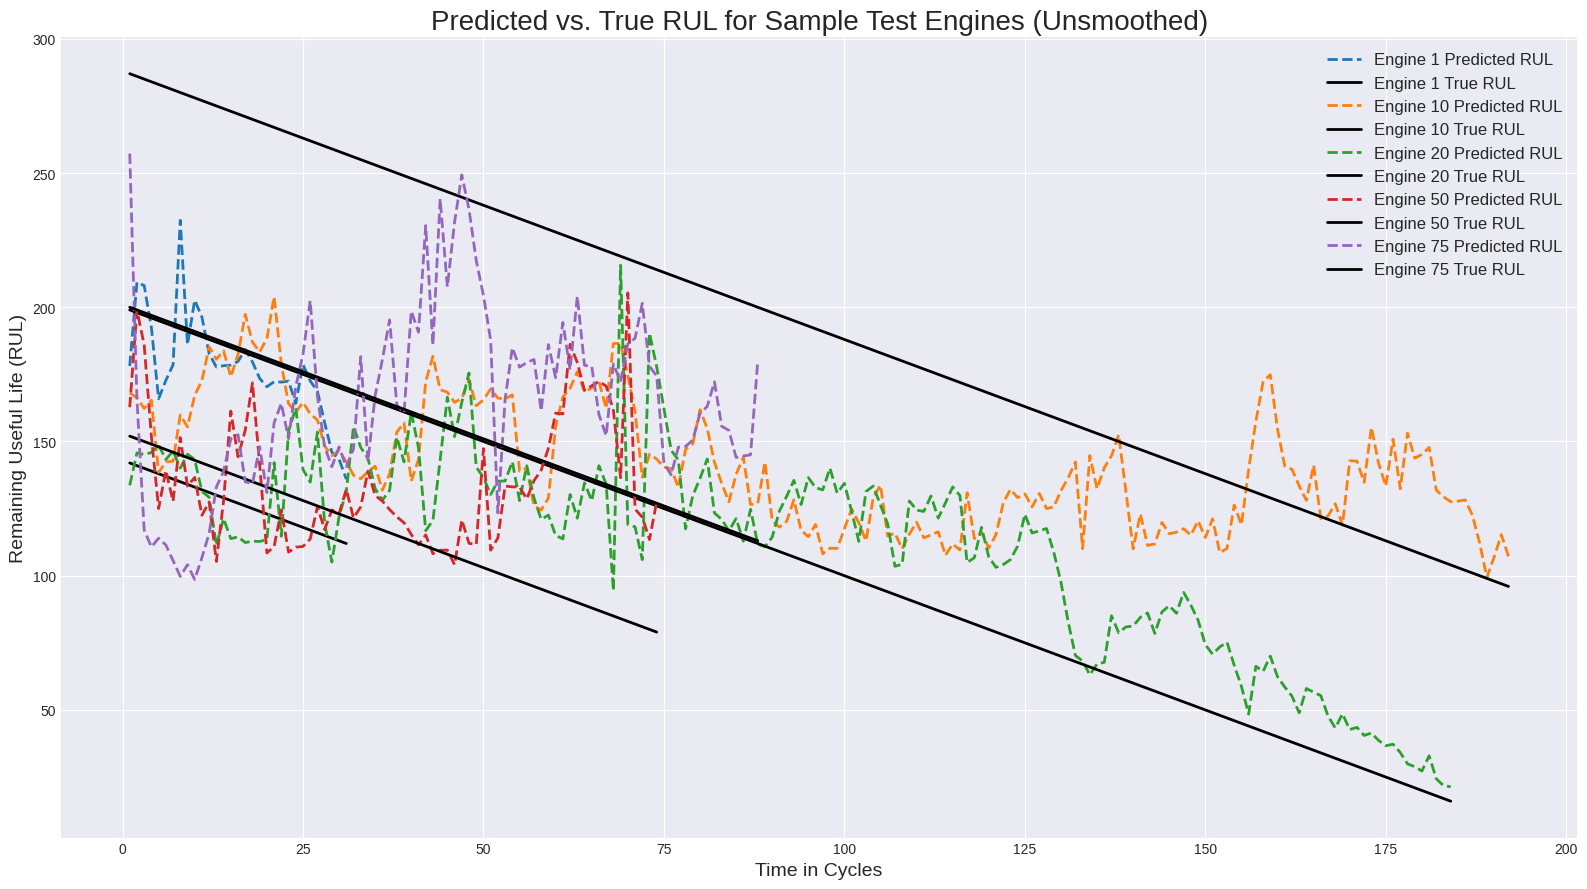

In [13]:
# Plot 1: Raw predictions
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(16, 9))

# Pick some engines to show
sample_engines = [1, 10, 20, 50, 75]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, engine_id in enumerate(sample_engines):
    engine_data = test_results[test_results['unit_number'] == engine_id]

    # Plot predicted RUL
    plt.plot(engine_data['time_in_cycles'], engine_data['predicted_RUL'],
             label=f'Engine {engine_id} Predicted RUL',
             linestyle='--', color=colors[i], linewidth=2)

    # Plot true RUL
    plt.plot(engine_data['time_in_cycles'], engine_data['true_RUL'],
             label=f'Engine {engine_id} True RUL',
             color='black', linewidth=2, linestyle='-')

plt.title('Predicted vs. True RUL for Sample Test Engines (Unsmoothed)', fontsize=20)
plt.xlabel('Time in Cycles', fontsize=14)
plt.ylabel('Remaining Useful Life (RUL)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

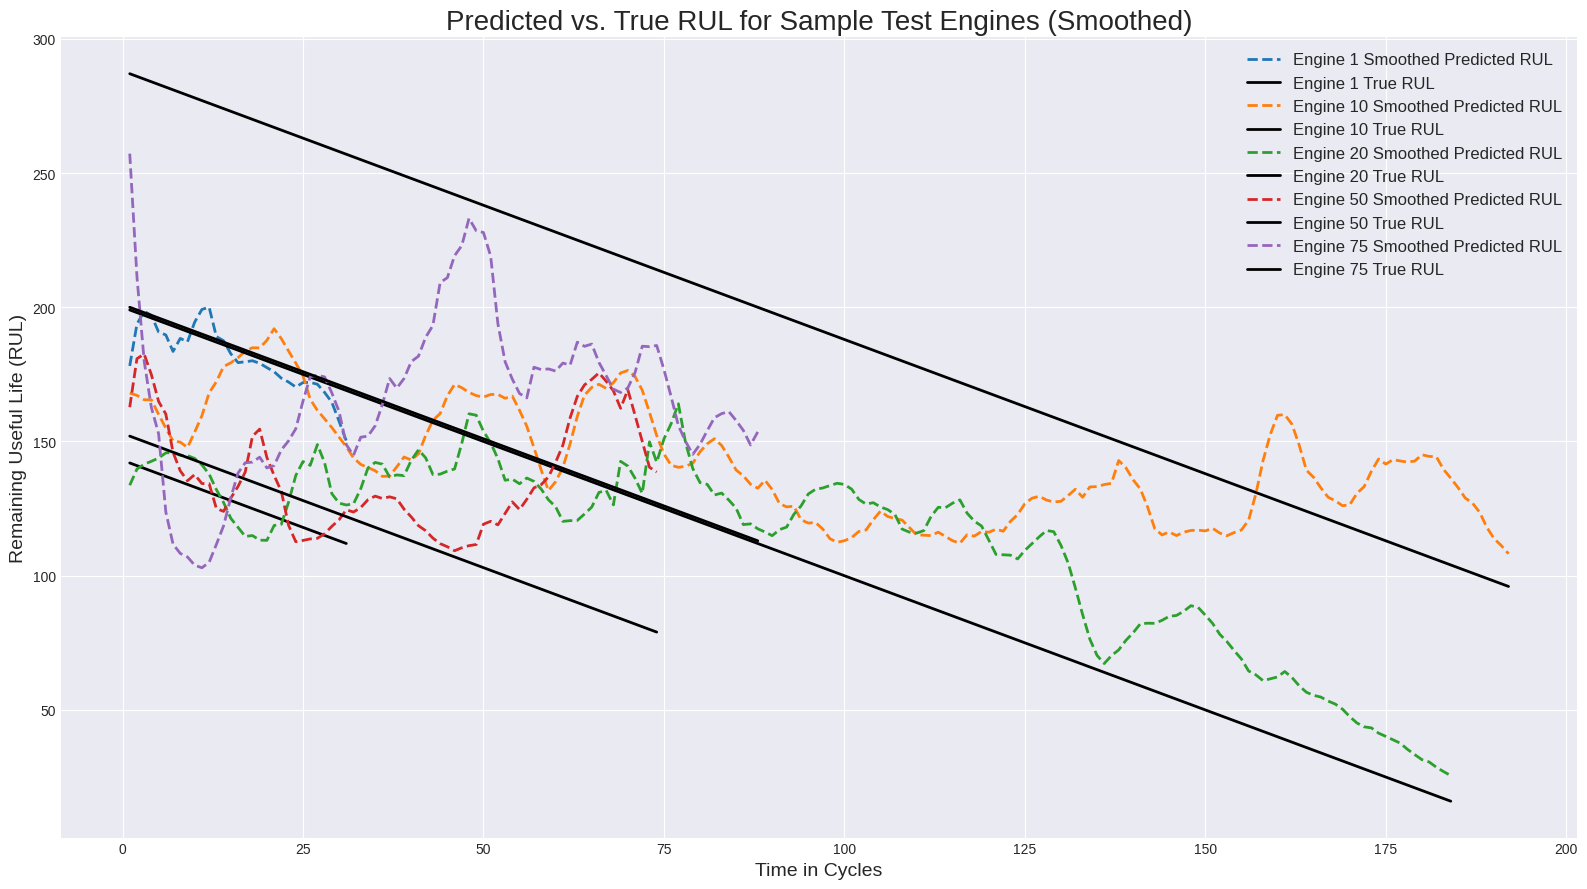

In [14]:
# Plot 2: Smoothed predictions
# Apply rolling average to make trends clearer

smoothing_window = 5
test_results_smooth = test_results.copy()
test_results_smooth['predicted_RUL'] = test_results_smooth.groupby('unit_number')['predicted_RUL'].transform(
    lambda x: x.rolling(window=smoothing_window, min_periods=1).mean()
)

plt.figure(figsize=(16, 9))

for i, engine_id in enumerate(sample_engines):
    engine_smooth = test_results_smooth[test_results_smooth['unit_number'] == engine_id]
    engine_true = test_results[test_results['unit_number'] == engine_id]

    plt.plot(engine_smooth['time_in_cycles'], engine_smooth['predicted_RUL'],
             label=f'Engine {engine_id} Smoothed Predicted RUL',
             linestyle='--', color=colors[i], linewidth=2)

    plt.plot(engine_true['time_in_cycles'], engine_true['true_RUL'],
             label=f'Engine {engine_id} True RUL',
             color='black', linewidth=2, linestyle='-')

plt.title('Predicted vs. True RUL for Sample Test Engines (Smoothed)', fontsize=20)
plt.xlabel('Time in Cycles', fontsize=14)
plt.ylabel('Remaining Useful Life (RUL)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
